In [1]:
import functools
import torch
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import Trainer, TrainingArguments, TrainerCallback

In [2]:
# Загрузка данных
df_train = pd.read_csv("files_rtf.csv")
df_test = pd.read_csv('sample.csv').dropna()
df_resh = pd.read_csv("resh.csv")
mem = pd.read_csv('mem.csv')

# Объединение датасетов
df_combined = pd.concat([df_train, df_test, df_resh,mem], ignore_index=True)

# Перемешивание данных
df_combined = df_combined.sample(frac=1, random_state=777).reset_index(drop=True)

# Инициализация и применение LabelEncoder
label_encoder = LabelEncoder()
df_combined['class'] = label_encoder.fit_transform(df_combined['class'])
df_combined['text'] = df_combined['text'].astype(str)

train_df, temp_df = train_test_split(df_combined, test_size=0.3, random_state=777)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=777)

# Создание датасетов для Hugging Face's datasets library
train_ds = Dataset.from_dict({'text': train_df['text'], 'class': train_df['class']})
val_ds = Dataset.from_dict({'text': val_df['text'], 'class': val_df['class']})
test_ds = Dataset.from_dict({'text': test_df['text'], 'class': test_df['class']})
datasets = DatasetDict({'train': train_ds, 'val': val_ds, 'test': test_ds})

In [3]:
df_combined

,Unnamed: 0,class,text,document_id,document_text
0,253.0,8,МИНИСТЕРСТВО СЕЛЬСКОГО ХОЗЯЙСТВА РОССИЙСКОЙ ФЕ...,NaN,NaN
1,104.0,4,Зарегистрировано в Минюсте РФ 25 августа 1992 ...,NaN,NaN
2,572.0,2,СОГЛАШЕНИЕ\n\nО ПРИМЕНЕНИИ В ЕВРАЗИЙСКОМ ЭКОНО...,NaN,NaN
3,NaN,9,ДОВЕРЕННОСТЬ\r\n\r\nг. Нижний Новгород ...,NaN,NaN
4,410.0,2,ФЕДЕРАЛЬНАЯ НАЛОГОВАЯ СЛУЖБА\n\nN ММВ-23-11/2@...,NaN,NaN
...,...,...,...,...,...
1468,639.0,2,Утверждено\n\nрешением Правления\n\nГосударств...,NaN,NaN
1469,71.0,4,ДОГОВОР\n\nот 22 июня 1973 года\n\nО ВЗАИМНОМ ...,NaN,NaN
1470,NaN,0,"М.П.\r\nЗАО ""СФЕРА""\r\nАкт\r\nоб установлении ...",NaN,NaN
1471,NaN,9,Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого янва...,NaN,NaN


In [4]:
# Загрузка токенизатора и модели
model_name = 'DeepPavlov/distilrubert-base-cased-conversational'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция токенизации
def tokenize_examples(examples, tokenizer):
    tokenized_inputs = tokenizer(examples['text'], max_length=512, padding="max_length", truncation=True)
    tokenized_inputs['labels'] = examples['class']
    return tokenized_inputs

# Токенизация датасетов
tokenized_datasets = datasets.map(functools.partial(tokenize_examples, tokenizer=tokenizer), batched=True)
tokenized_datasets = tokenized_datasets.with_format('torch')

# Загрузка модели
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df_combined['class'])))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Map:   0%|          | 0/1031 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attentio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [5]:
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    labels = p.label_ids
    decoded_labels = label_encoder.inverse_transform(labels)
    f1_weighted = f1_score(decoded_labels, decoded_predictions, average='weighted')
    return {'f1_weighted': f1_weighted}

In [6]:
# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True
)

# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
    compute_metrics=lambda p: {"f1_weighted": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')},
    tokenizer=tokenizer,
)

# Начало тренировки модели
trainer.train()

c:\sochi\.venv\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
# Выполнение предсказаний на тестовом датасете
test_results = trainer.predict(tokenized_datasets['test'])

# Получение предсказанных меток и реальных меток
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

# Вычисление метрик
test_f1_weighted = f1_score(true_labels, predictions, average='weighted')
print(f"F1-Score (Weighted) on Test Set: {test_f1_weighted}")

  0%|          | 0/7 [00:00<?, ?it/s]

F1-Score (Weighted) on Test Set: 0.8370141071915652


In [ ]:
# Выполнение предсказаний на тестовом датасете
test_results = trainer.predict(tokenized_datasets['test'])

# Получение предсказанных меток и реальных меток
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

# Вычисление метрик
test_f1_weighted = f1_score(true_labels, predictions, average='weighted')
print(f"F1-Score (Weighted) on Test Set: {test_f1_weighted}")

In [9]:
# Выполнение предсказаний на тестовом датасете, если это еще не сделано
test_results = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

  0%|          | 0/7 [00:00<?, ?it/s]

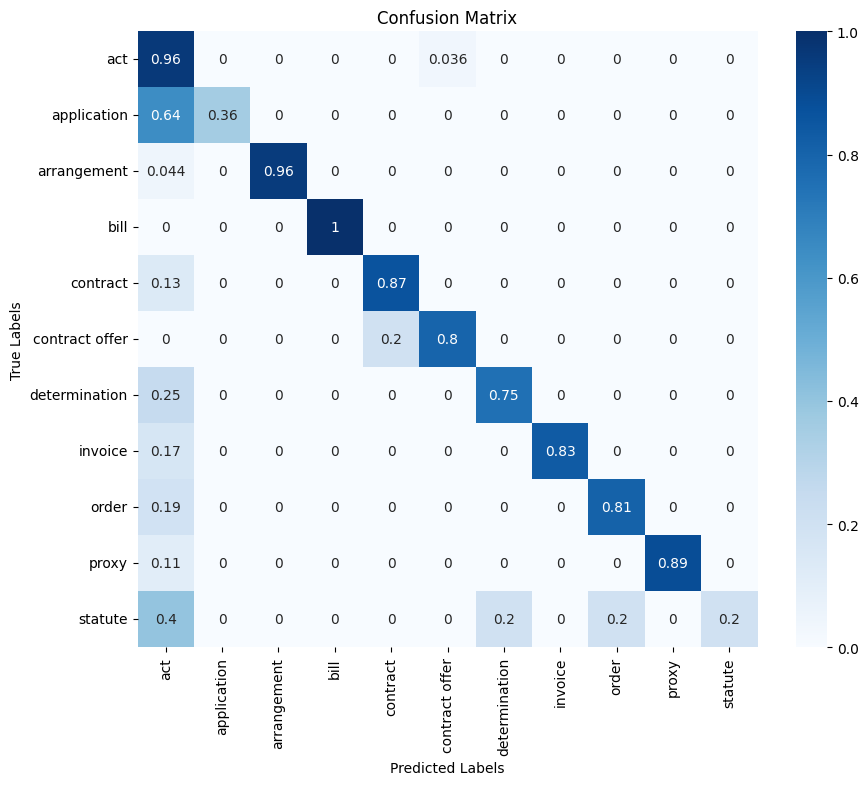

In [10]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(true_labels, predictions, normalize='true')

# Визуализация матрицы ошибок
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Вывод отчета по классификации
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

           act       0.44      0.96      0.61        28
   application       1.00      0.36      0.53        14
   arrangement       1.00      0.96      0.98        45
          bill       1.00      1.00      1.00         5
      contract       0.96      0.87      0.91        30
contract offer       0.80      0.80      0.80         5
 determination       0.90      0.75      0.82        12
       invoice       1.00      0.83      0.91         6
         order       0.98      0.81      0.88        62
         proxy       1.00      0.89      0.94         9
       statute       1.00      0.20      0.33         5

      accuracy                           0.83       221
     macro avg       0.92      0.77      0.79       221
  weighted avg       0.91      0.83      0.84       221



In [12]:
label2id = {k: v for v, k in enumerate(label_encoder.classes_)}
id2label = {y:x for x,y in label2id.items()}
trainer.model.config.label2id = label2id
trainer.model.config.id2label = id2label
trainer.model.config.id2label

{0: 'act',
 1: 'application',
 2: 'arrangement',
 3: 'bill',
 4: 'contract',
 5: 'contract offer',
 6: 'determination',
 7: 'invoice',
 8: 'order',
 9: 'proxy',
 10: 'statute'}

In [13]:
model_path = "./best_model"
trainer.model.save_pretrained(model_path)
trainer.tokenizer.save_pretrained(model_path)

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')